In [8]:
import geopandas as gpd
import sys
import os

from Source.Street_Map_Extraction.OSMnXRetriever import OSMnXWalkCityRetriever
from Source.Street_Map_Extraction.StreetSampleTools import StreetSampler
import geopandas as gpd

### Getting the network of streets

The class OSMnXWalkCityRetriever encapsulates some methods to retrieve street networks through OSMnX. There is one that finds the streets within a polygon, here i will show the one that obtains the network within a radius centered at a point (longitude, latitude). This is just like using the osmnx library but having my own names for the methods makes things faster for me. 

Exported Geojson


<Axes: >

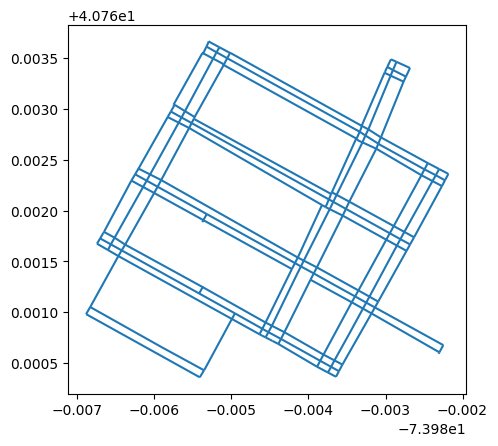

In [2]:
latitude = 40.762117282576774
longitude =  -73.98452519564609
radius = 200

retriever = OSMnXWalkCityRetriever()
graph = retriever.getGraphFromCoordinates(latitude, longitude, radius)
outputPath = os.path.join(os.getcwd(), "Data", "network.geojson")
if(not os.path.exists(outputPath)):
    retriever.exportGeoJSON(graph, outputPath)


gdf = gpd.read_file(outputPath)
gdf.plot()

### Sampling the streets

To sample the streets right now what i do is assign a maximum of points that i want to sample, for instance $N_{\text{max}} = 200$. This is approximate because if there are more streets than points then it will have to be bigger so that every street gets imaged. Based on that parameter the number of images that are assigned to the $i-$th street is:

\begin{equation}
N_{i} = \left\lfloor \frac{L_{i}}{\sum_{i}L{i}}N_{\text{max}}\right\rfloor
\end{equation}






El número de calles muestreadas es 171


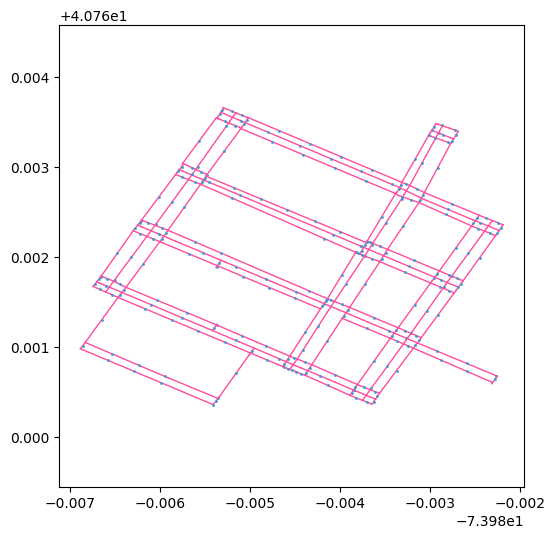

In [3]:
nMax = 200
streetSampler = StreetSampler(nMax)
streetSampler.openStreetsWithDataFrame(gdf)
print(f"El número de calles muestreadas es {len(streetSampler.streets)}")
streetSampler.sampleStreetsNoIntersections()
streetSampler.drawSamplingScheme(width = 6, height = 6, edgeColor = "#FF4D9E", edgeSize = 1, pointColor = "#3A9AD9", nodeSize = 1)


### Getting the images

There are different Collection Geometries for image collection. CollectionGeometry.POINT collects 8 images spanning 360 degrees. This might make analysis costly in terms of the number of images that are obtained, but it is necessary for obtaining some metrics like SVF. When you have the 8 views you are also able to separate those that are closest to being a view pointing to the sidewalk. This is what CollectionGeometry.COMBINED_VIEW does. It extracts the 8 images and makes a copy of the sidewalk views storing them in another folder. I need the 8 images for SVF, i need the sidewalk views for everything else, so this is a convenient method for me. 

However, here i will just illustrate how to obtain the sidewalk views, first you need to know the directions of each of the streets (bearings), so that you can rotate 90 degrees and -90 degrees from there to look at the sidewalk. The collection geometry that receives points and bearings is called CollectionGeometry.STREET_BEARING.

In [4]:
from Source.Image_Extraction.StreetViewTools_2 import CollectionGeometry
from Source.Image_Extraction.StreetViewTools_2 import GoogleStreetViewCollector
from tqdm import tqdm

collectionGeometry = CollectionGeometry.STREET_BEARING
outputFolder = os.path.join(os.getcwd(), "Data", "Images_2")

apiKey = ""
collector = GoogleStreetViewCollector(apiKey)

streets = streetSampler.streets
for i in tqdm(range(0,len(streets))):
    street = streets[i]
    points, bearings = street.getGooglePointsAndBearings()
    #Segments that don't have name in the geojson are labelled as unnamed_{index}, i have not figured out how to solve this so that all names are assigned
    streetName = street.streetId
    outputPath = os.path.join(os.getcwd(), "Data", "Images_2", streetName)
    #collector.collectPictures(collectionGeometry, outputPath, points, bearings)
    




100%|██████████| 171/171 [00:00<00:00, 9558.55it/s]


### Extra - image analysis and mapping

Here i show very quick how i would analyze images using YOLO models and map them. I have classes i created for that to make my life easier but here i will do it manually so that i don't add unnecessary complexity to the notebook. I know my coding sucks, i am sorry. 

In [5]:
from Source.Utils.FacadeSegmentator import FacadeSegmentator
from Source.Utils.FacadeSegmentator import BuildingProperty
from PIL import Image
import numpy as np
from Source.Utils.Utilities import CSVManager
from tqdm import tqdm

modelPath = os.path.join(os.getcwd(), "Data", "facade_segmentation_150.pt")

facadeSegmentator = FacadeSegmentator(modelPath)
propertyToExtract = BuildingProperty.VEGETATION
vegetationIndexValues = []

streets = streetSampler.streets
for i in tqdm(range(0,len(streets))):
    street = streets[i]
    streetFolder = os.path.join(os.getcwd(), "Data", "Images_2", street.streetId)
    #Extract all images in the folder
    imageFiles = [
    os.path.join(root, file)
    for root, _, files in os.walk(streetFolder)
    for file in files
    if file.lower().endswith('.jpg')
    ]

    nImages = len(imageFiles)
    vegetationValue = 0
    for j in range(0,nImages):
        imgPath = imageFiles[j]
        img = np.array(Image.open(imgPath))
        segmentationResults = facadeSegmentator.segmentFacadesInImage(img)
        masks = segmentationResults[propertyToExtract][0]
        #Construct the combined mask
        imgShape = img.shape[:2]
        combinedMask = np.zeros(imgShape, dtype=bool)
        for mask in masks:
            combinedMask |= mask.astype(bool)
        #Obtain the vegetation index
        vegetationValue = vegetationValue + (1/nImages)*(np.sum(combinedMask)/(imgShape[0]*imgShape[1]))
    vegetationIndexValues.append(vegetationValue)

#Technically speaking you can directly tag the street sampler with the feature values but i like to have the CSV better
#so that you don't have to repeat this operation multiple times.

csvExporter = CSVManager()
csvOutputPath = os.path.join(os.getcwd(), "Data", "vegetation_values_method_2.csv")

csvExporter.exportCSV(["Vegetation"], [[x] for x in vegetationIndexValues], csvOutputPath)



100%|██████████| 171/171 [02:31<00:00,  1.13it/s]


In [6]:
from Source.Utils.Utilities import CSVManager
csvManager= CSVManager()
header, data = csvManager.readCSV(csvOutputPath)
data = [float(x[0]) for x in data]
attributeName = "Vegetation Index"

streetSampler.tagStreets(attributeName, data)

Tagging finished


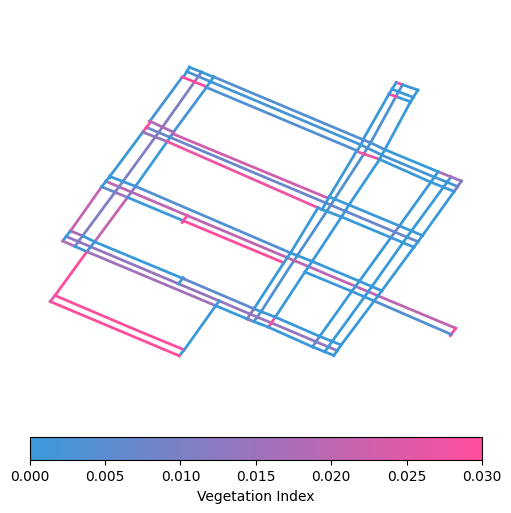

In [7]:
from Source.Utils.AttributeStreetVisualizer import StreetAttributesVisualizer
from Source.Utils.AttributeStreetVisualizer import VariableType

variableType = VariableType.CONTINUOUS
attributeVisualizer = StreetAttributesVisualizer(streetSampler)
width = 5
height = 5
edgeSize = 2
minValueColor = np.array([58/255, 153/255, 217/255])
maxValueColor = np.array([255/255, 77/255, 157/255])

attributeVisualizer.colorByAttribute(attributeName, variableType, width, height, edgeSize, minValueColor, maxValueColor, minValue = 0, maxValue = 0.03)

In [ ]:
street